# Fine-tune Model1 on Dataset AB

## Mount Google Drive


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls -la /content/drive/MyDrive/dissertation/datasets/

total 10266107
-rw------- 1 root root  340216752 May 11 18:59 cyclegan_checkpoints_v2.weights.h5
-rw------- 1 root root  340216752 May 10 20:17 cyclegan_checkpoints.weights.h5
-rw------- 1 root root  340216752 May 10 20:59 cyclegan_checkpoints.weights.v2.h5
-rw------- 1 root root  332723447 May 11 17:26 dataseta2.tar.gz
-rw------- 1 root root  191213337 May 10 18:12 dataseta.tar.gz
-rw------- 1 root root  320580182 May 11 17:48 dataseta.v2.tar.gz
-rw------- 1 root root  106589230 May 10 18:54 datasetb.tar.gz
-rw------- 1 root root  150727497 May 11 17:49 datasetb.v2.tar.gz
-rw------- 1 root root  139308205 May 11 20:05 finetuning_dataset.v2.tar.gz
-rw------- 1 root root  132842444 May 10 22:17 finetuninnd_dataset.tar.gz
-rw------- 1 root root 6049340023 Apr 30 20:06 orthos.zip
-rw------- 1 root root 2068515848 May 16 15:12 spain.zip


In [3]:
!cp /content/drive/MyDrive/dissertation/datasets/finetuning_dataset.v2.tar.gz ./

In [4]:
!tar -xzf ./finetuning_dataset.v2.tar.gz

In [5]:
!ls -la ./finetuning_dataset2/train/masks/ | head

total 10096
drwxr-xr-x 2 root root 110592 May 11 19:21 .
drwxr-xr-x 4 root root   4096 May 11 19:30 ..
-rw-r--r-- 1 root root   1636 May 11 20:02 mask_color_0000.png
-rw-r--r-- 1 root root   1216 May 11 20:02 mask_color_0001.png
-rw-r--r-- 1 root root   2481 May 11 20:02 mask_color_0002.png
-rw-r--r-- 1 root root   1324 May 11 20:02 mask_color_0003.png
-rw-r--r-- 1 root root   3250 May 11 20:02 mask_color_0004.png
-rw-r--r-- 1 root root   3126 May 11 20:02 mask_color_0005.png
-rw-r--r-- 1 root root   1832 May 11 20:02 mask_color_0006.png


In [6]:
# check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import os

# import libs for processing images
import imageio
from PIL import Image

# import visualizations
import matplotlib.pyplot as plt

import numpy as np

# TF and co
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy


Sat May 17 18:12:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
def load_images(folder_path):

    image_list = []

    if not os.path.isdir(folder_path):
        return np.array([])

    filenames = sorted(os.listdir(folder_path))

    for filename in filenames:


      img_path = os.path.join(folder_path, filename)
      try:
          with Image.open(img_path) as img:

              img_array = np.array(img)
              image_list.append(img_array)


      except Exception as e:
              print(f"Warning: Error processing image {img_path}: {e}. Skipping.")

    if not image_list:
        print("No images were successfully loaded.")
        return np.array([])

    try:

        numpy_array_of_images = np.stack(image_list, axis=0)
        return numpy_array_of_images
    except ValueError as e:
        return np.array([])

In [8]:
masks = load_images('./finetuning_dataset2/train/masks/')

In [9]:
masks.shape

(2432, 256, 256, 3)

### Prepare Masks for learning

In [10]:
def create_binary_mask_from_specific_color(rgb_image_array, target_color_rgb):
    if not isinstance(rgb_image_array, np.ndarray) or rgb_image_array.ndim != 3 or rgb_image_array.shape[-1] != 3:
        raise ValueError("Input 'rgb_image_array' must be a NumPy array with shape (H, W, 3).")
    if not isinstance(target_color_rgb, tuple) or len(target_color_rgb) != 3:
        raise ValueError("'target_color_rgb' must be an (R, G, B) tuple.")

    matches = np.all(rgb_image_array == np.array(target_color_rgb), axis=2)
    binary_mask_2d = matches.astype(np.uint8)
    binary_mask_hw1 = np.expand_dims(binary_mask_2d, axis=-1)

    return binary_mask_hw1

In [11]:
target_red = (128, 0, 0)
Y_masks_processed = np.array(
    [create_binary_mask_from_specific_color(masks[i], target_red) for i in range(masks.shape[0])]
)

In [12]:
Y_masks_processed.shape

(2432, 256, 256, 1)

In [13]:
print(np.unique(Y_masks_processed))

[0 1]


In [14]:
images = load_images('./finetuning_dataset2/train/images')

In [15]:
import numpy as np
from PIL import Image
import os

def PreprocessData(loaded_images, processed_masks, target_shape_img, target_shape_mask):

    m = len(loaded_images)
    if m == 0:
        print("Warning: No images/masks provided to PreprocessData_v2.")
        return np.zeros((0, *target_shape_img), dtype=np.float32), np.zeros((0, *target_shape_mask), dtype=np.int32)

    i_h, i_w, i_c = target_shape_img
    m_h, m_w, m_c = target_shape_mask
    if m_c != 1:
        print(f"Warning: target_shape_mask expects {m_c} channels, but semantic segmentation usually requires 1.")

    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)

    print(f"Preprocessing {m} image/mask pairs...")


    for index, (img_array, mask_array) in enumerate(zip(loaded_images, processed_masks)):
        try:

            if img_array.dtype != np.uint8:
                 img_array = img_array.astype(np.uint8)
            pil_img = Image.fromarray(img_array)

            pil_img = pil_img.convert('RGB')
            pil_img_resized = pil_img.resize((i_w, i_h), Image.Resampling.LANCZOS)
            img_resized_array = np.array(pil_img_resized)
            X[index] = img_resized_array.astype(np.float32) / 255.0


            if mask_array.ndim != 2:
                print(f"Warning: Mask at index {index} has {mask_array.ndim} dims, expected 2. Trying first channel.")
                mask_array = mask_array[:, :, 0]
            if mask_array.dtype != np.uint8:
                mask_array = mask_array.astype(np.uint8)
            pil_mask = Image.fromarray(mask_array)
            pil_mask_resized = pil_mask.resize((m_w, m_h), Image.Resampling.NEAREST)
            mask_resized_array = np.array(pil_mask_resized)
            adjusted_mask_array = mask_resized_array
            y[index] = np.expand_dims(adjusted_mask_array, axis=-1).astype(np.int32)

        except Exception as e:
            print(f"Error processing data at index {index}: {e}. Skipping pair.")

    print("Finished preprocessing.")
    return X, y


Displaying 5 example(s):

Image 0:
  Shape: (256, 256, 3), dtype: uint8
Mask 0:
  Shape: (256, 256, 1), dtype: uint8
  Unique mask values: [0 1]


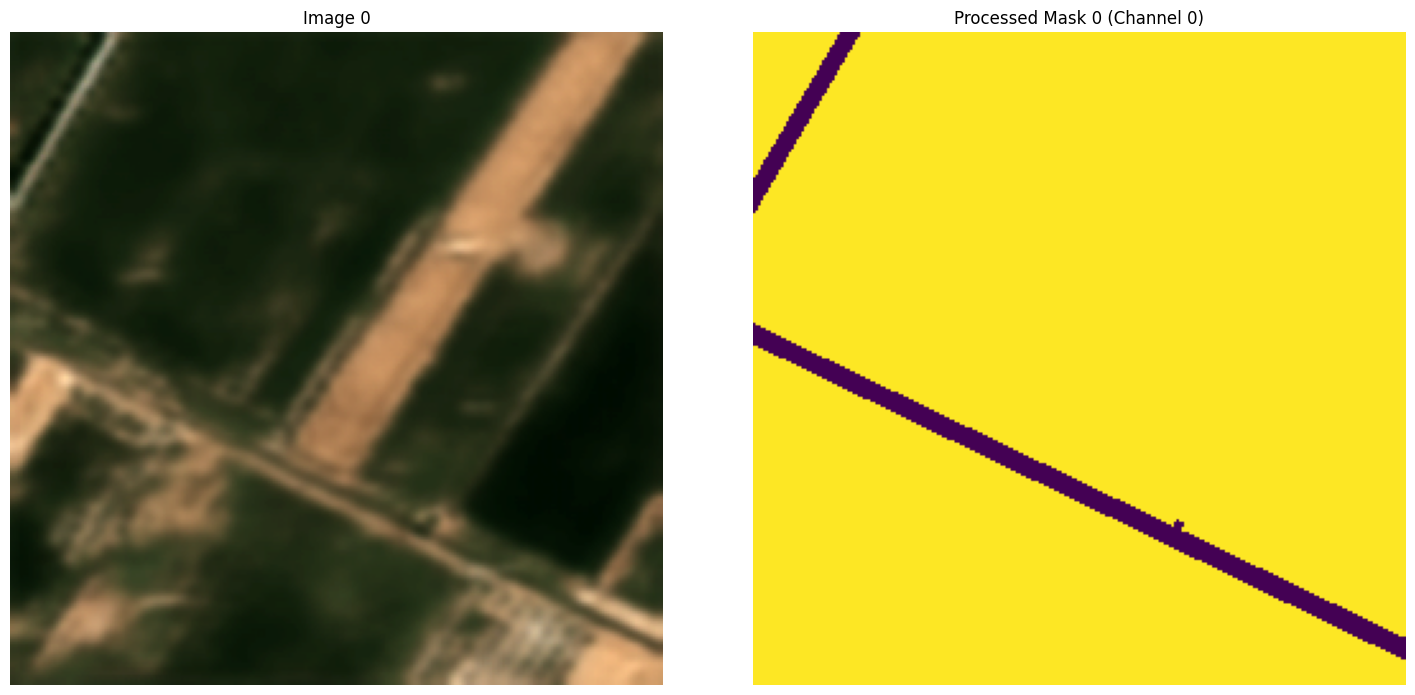


Image 1:
  Shape: (256, 256, 3), dtype: uint8
Mask 1:
  Shape: (256, 256, 1), dtype: uint8
  Unique mask values: [0 1]


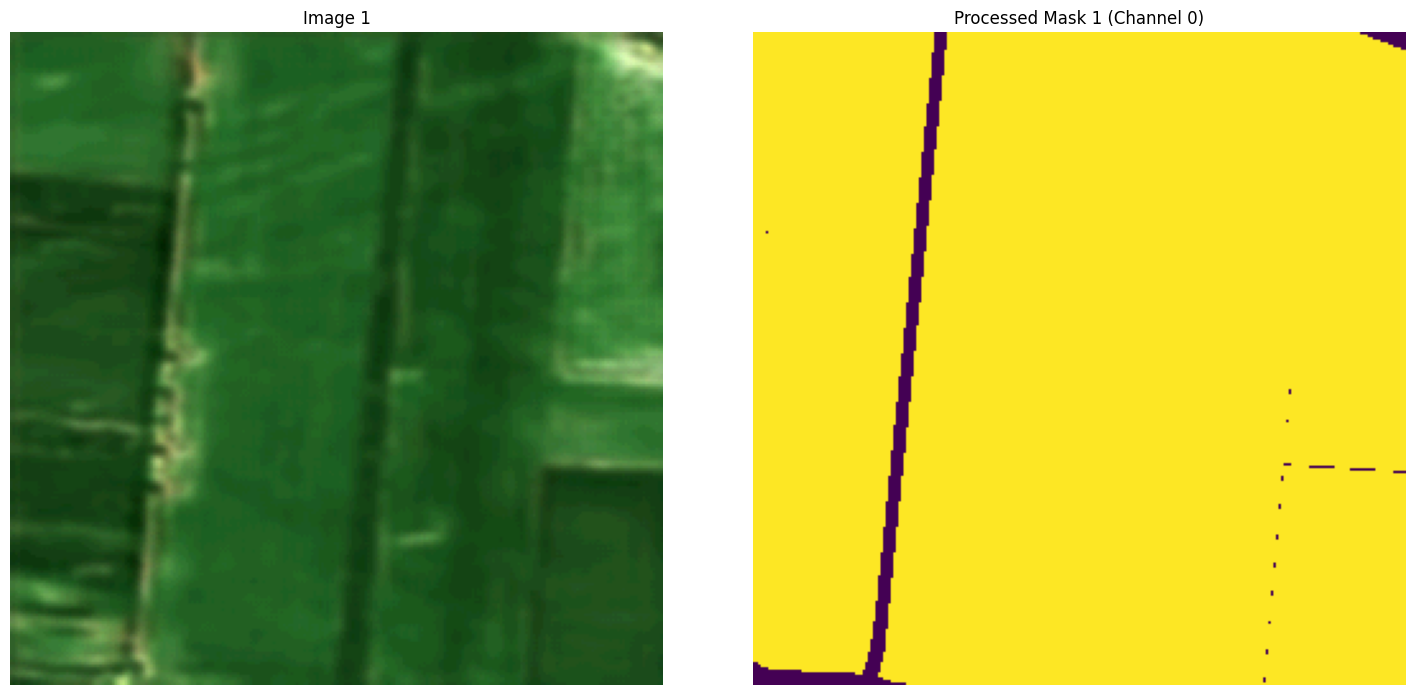


Image 2:
  Shape: (256, 256, 3), dtype: uint8
Mask 2:
  Shape: (256, 256, 1), dtype: uint8
  Unique mask values: [0 1]


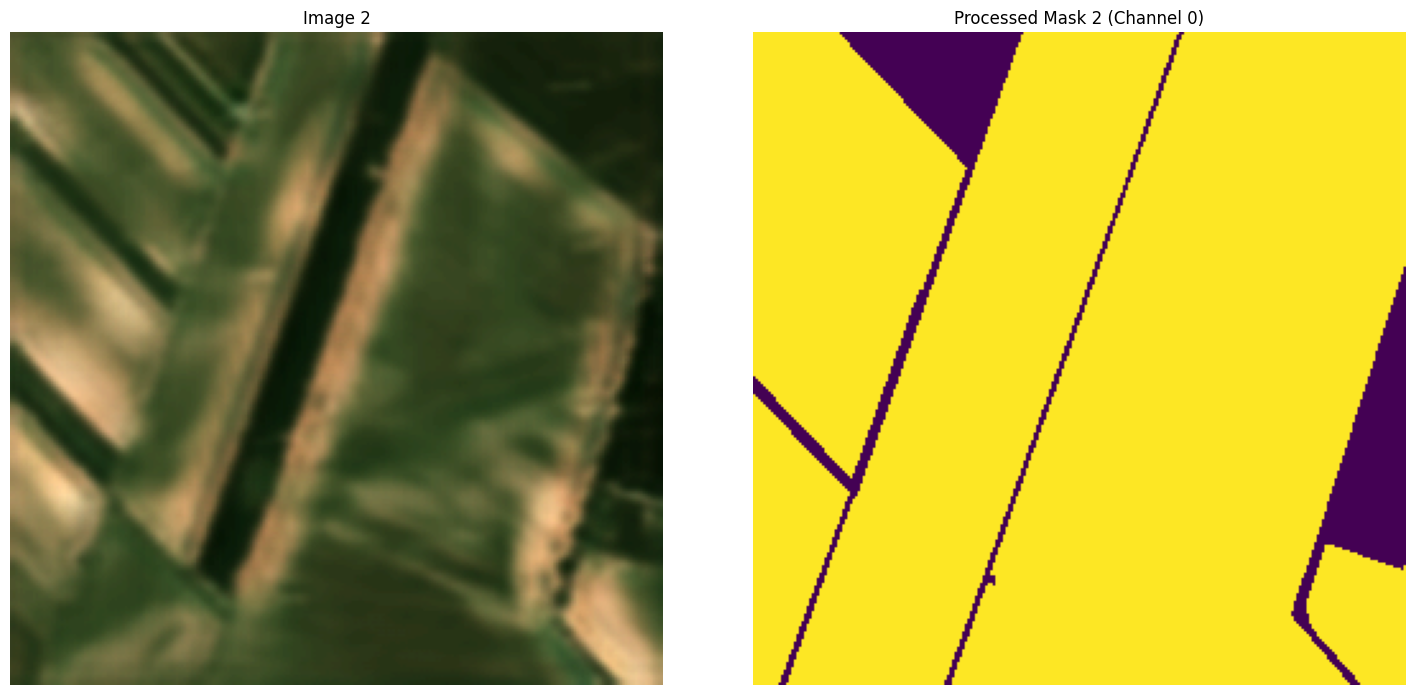


Image 3:
  Shape: (256, 256, 3), dtype: uint8
Mask 3:
  Shape: (256, 256, 1), dtype: uint8
  Unique mask values: [0 1]


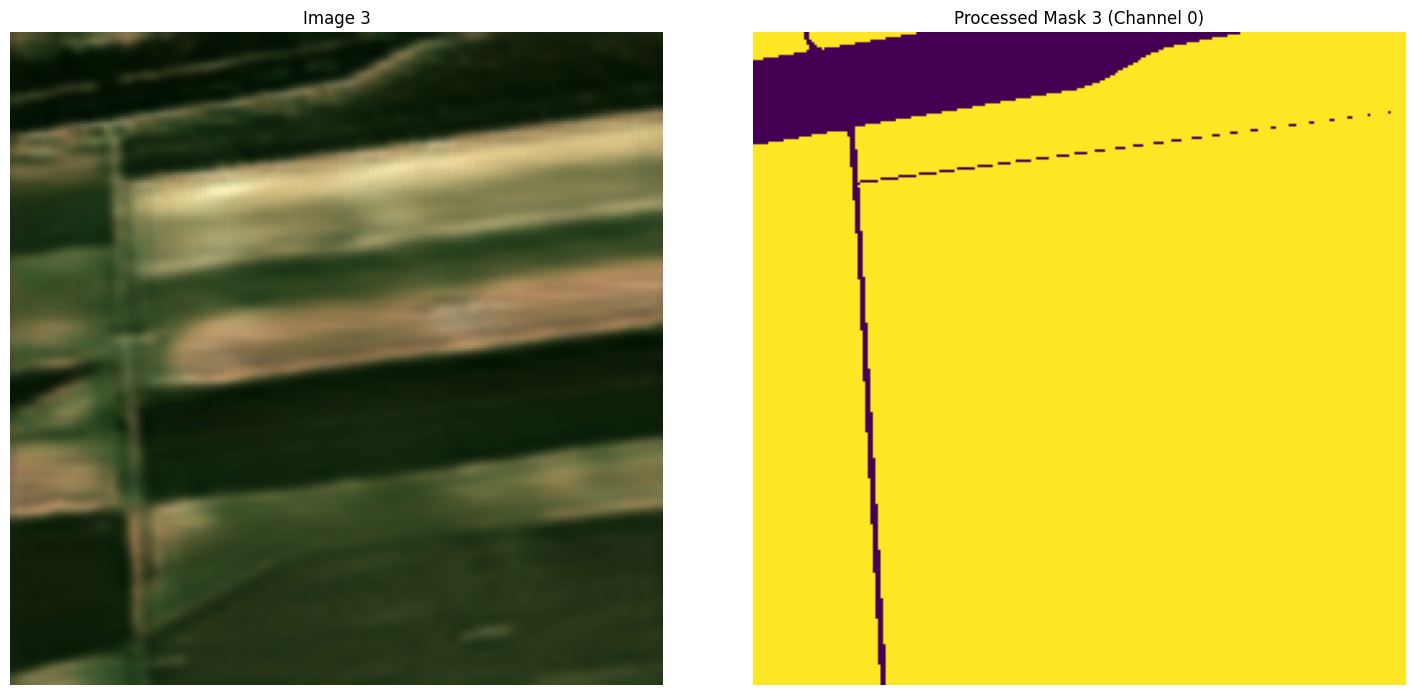


Image 4:
  Shape: (256, 256, 3), dtype: uint8
Mask 4:
  Shape: (256, 256, 1), dtype: uint8
  Unique mask values: [0 1]


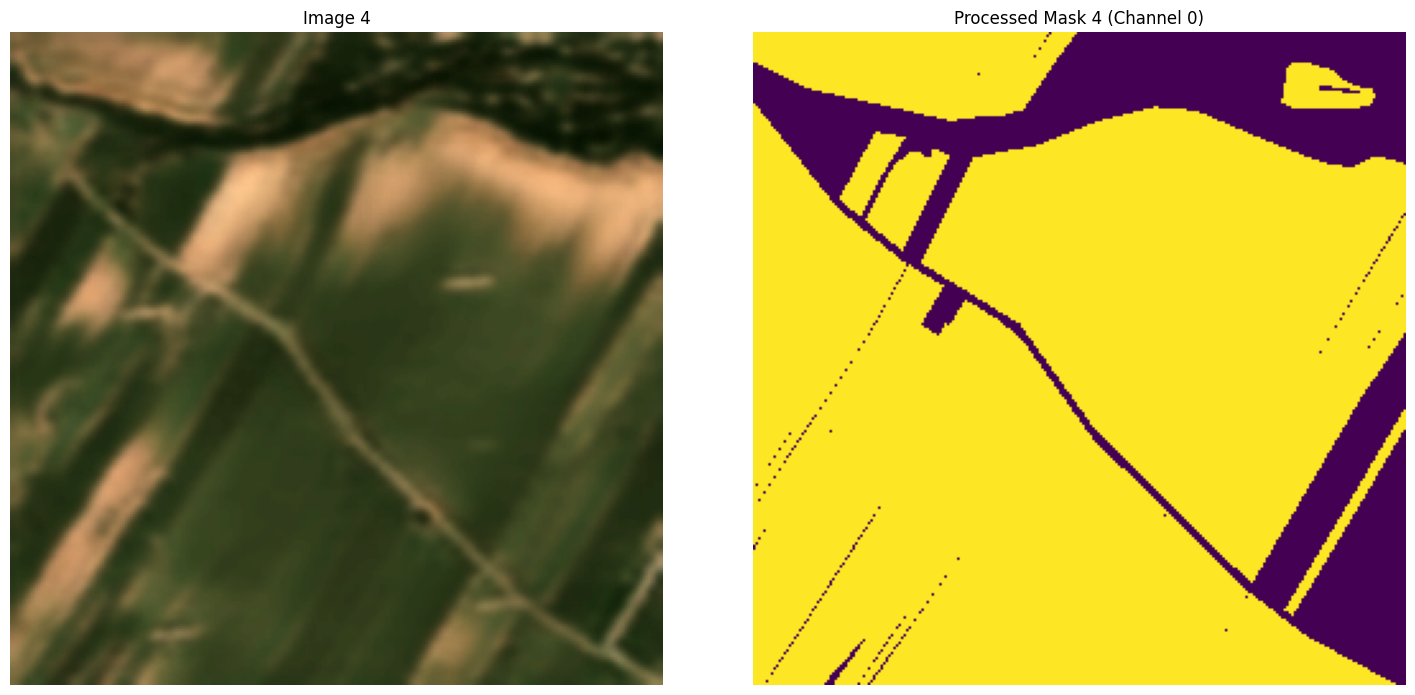

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile

img = images
mask = Y_masks_processed

if img.any() and mask.any():
    # View an example of image and corresponding mask
    show_images = min(5, len(img))
    print(f"\nDisplaying {show_images} example(s):")
    for i in range(show_images):

        img_view = img[i]
        mask_view = mask[i]


        print(f"\nImage {i}:")
        print(f"  Shape: {img_view.shape}, dtype: {img_view.dtype}")
        print(f"Mask {i}:")
        print(f"  Shape: {mask_view.shape}, dtype: {mask_view.dtype}")
        print(f"  Unique mask values: {np.unique(mask_view)}")

        fig, arr = plt.subplots(1, 2, figsize=(15, 7))

        # Display image
        arr[0].imshow(img_view)
        arr[0].set_title(f'Image {i}')
        arr[0].axis('off')

        # Display mask
        arr[1].imshow(mask_view, cmap='viridis')
        arr[1].set_title(f'Processed Mask {i} (Channel 0)')
        arr[1].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("\nNo data loaded, skipping display.")

### Prepare train dataset

Preprocessing 2432 image/mask pairs...
Finished preprocessing.

Class distribution in y_train (after resizing):
  Class 0: 97423773 pixels (61.13%)
  Class 1: 61959779 pixels (38.87%)

Processed Shapes:
X_train Shape: (2432, 256, 256, 3)
y_train shape: (2432, 256, 256, 1)

Visualizing processed example index 0:


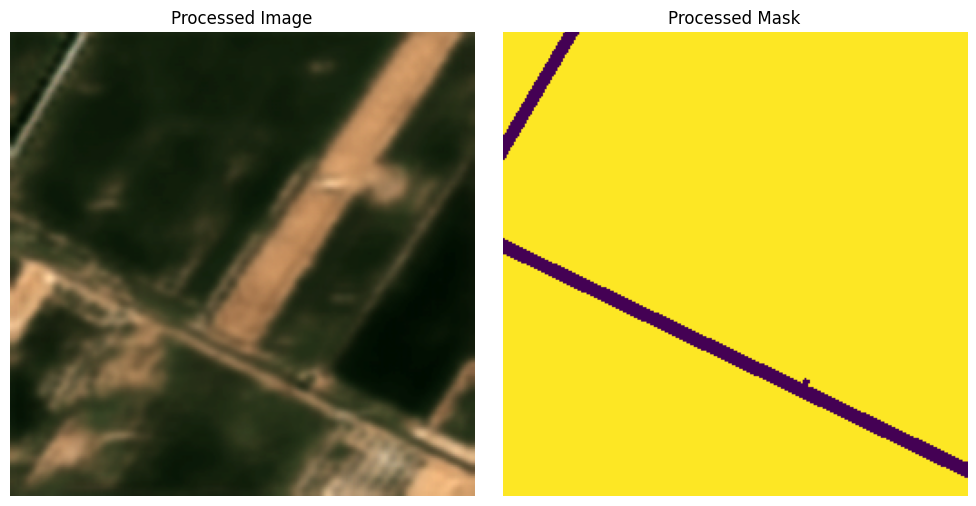

In [18]:

target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]


if 'img' in locals() and 'mask' in locals() and img.any() and mask.any():

    X_train, y_train = PreprocessData(img, mask, target_shape_img, target_shape_mask)


    if X_train.size > 0 and y_train.size > 0 :
        total_pixels = y_train.size
        unique_classes, counts = np.unique(y_train, return_counts=True)
        print("\nClass distribution in y_train (after resizing):")
        for cls, count in zip(unique_classes, counts):
            percentage = (count / total_pixels) * 100
            print(f"  Class {cls}: {count} pixels ({percentage:.2f}%)")


        print("\nProcessed Shapes:")
        print("X_train Shape:", X_train.shape)
        print("y_train shape:", y_train.shape)


        image_index = 0
        print(f"\nVisualizing processed example index {image_index}:")
        fig, arr = plt.subplots(1, 2, figsize=(10, 5))

        arr[0].imshow(X_train[image_index])
        arr[0].set_title('Processed Image')
        arr[0].axis('off')

        arr[1].imshow(np.squeeze(y_train[image_index]), cmap='viridis')
        arr[1].set_title('Processed Mask')
        arr[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("\nPreprocessing resulted in empty arrays.")
else:
    print("\nVariables 'img' and 'mask' not found or are empty.")

In [19]:
print(np.unique(y_train))

[0 1]


### Prepare validation dataset and show examples

In [20]:
from sklearn.model_selection import train_test_split


img_train, img_val, mask_train, mask_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True
)



Displaying 5 example(s):

Image 0:
  Shape: (256, 256, 3), dtype: float32
Mask 0:
  Shape: (256, 256, 1), dtype: int32
  Unique mask values: [0 1]


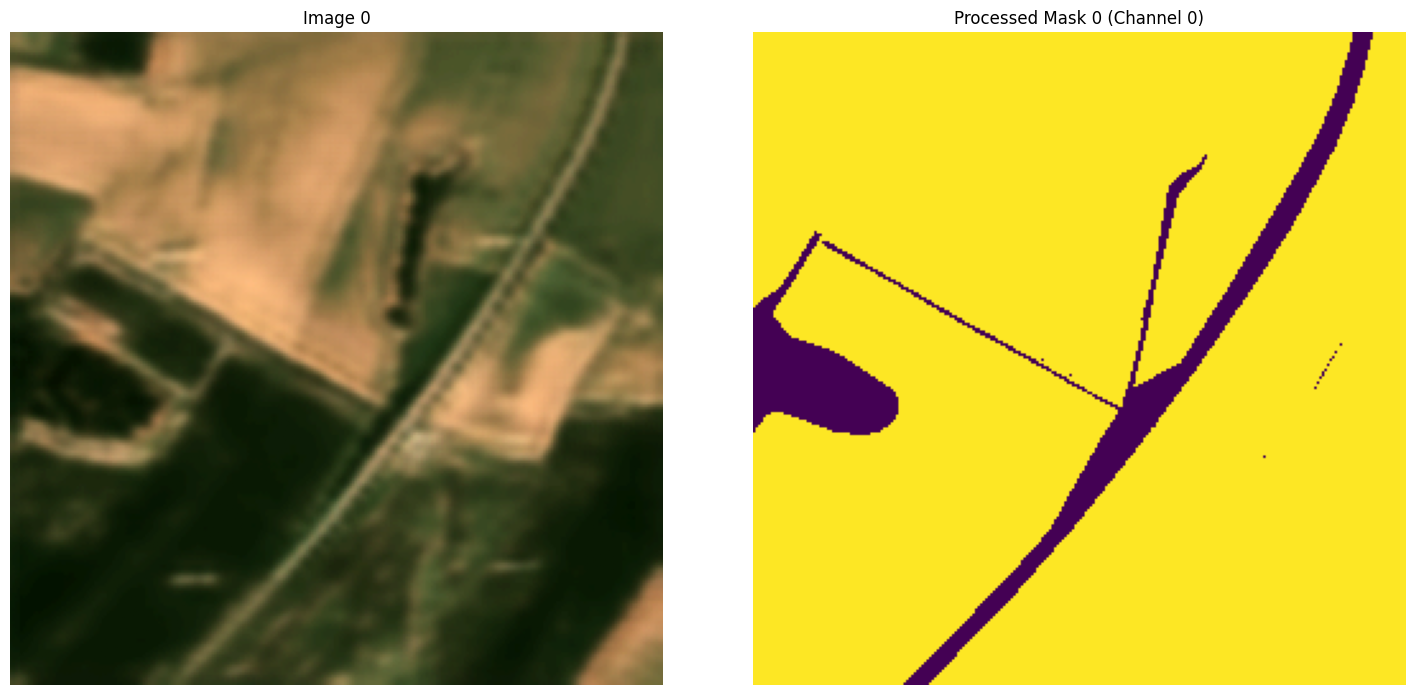


Image 1:
  Shape: (256, 256, 3), dtype: float32
Mask 1:
  Shape: (256, 256, 1), dtype: int32
  Unique mask values: [0 1]


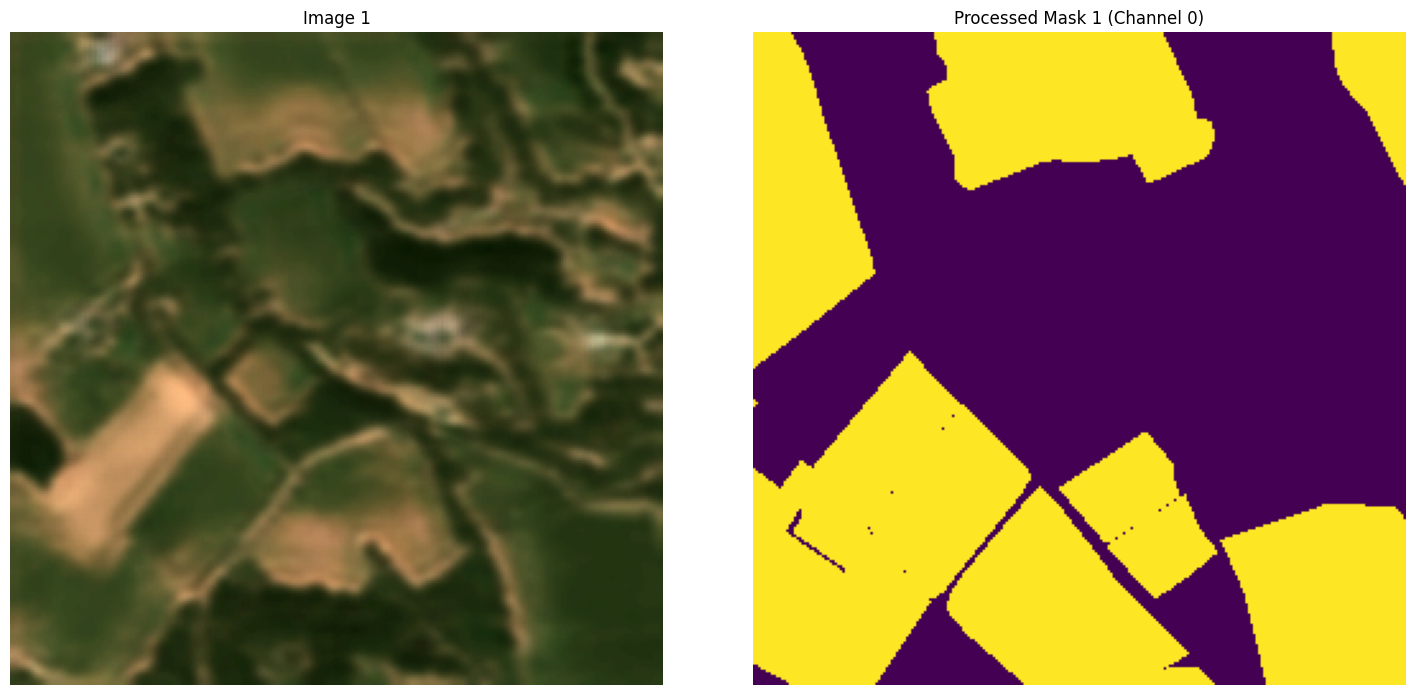


Image 2:
  Shape: (256, 256, 3), dtype: float32
Mask 2:
  Shape: (256, 256, 1), dtype: int32
  Unique mask values: [0 1]


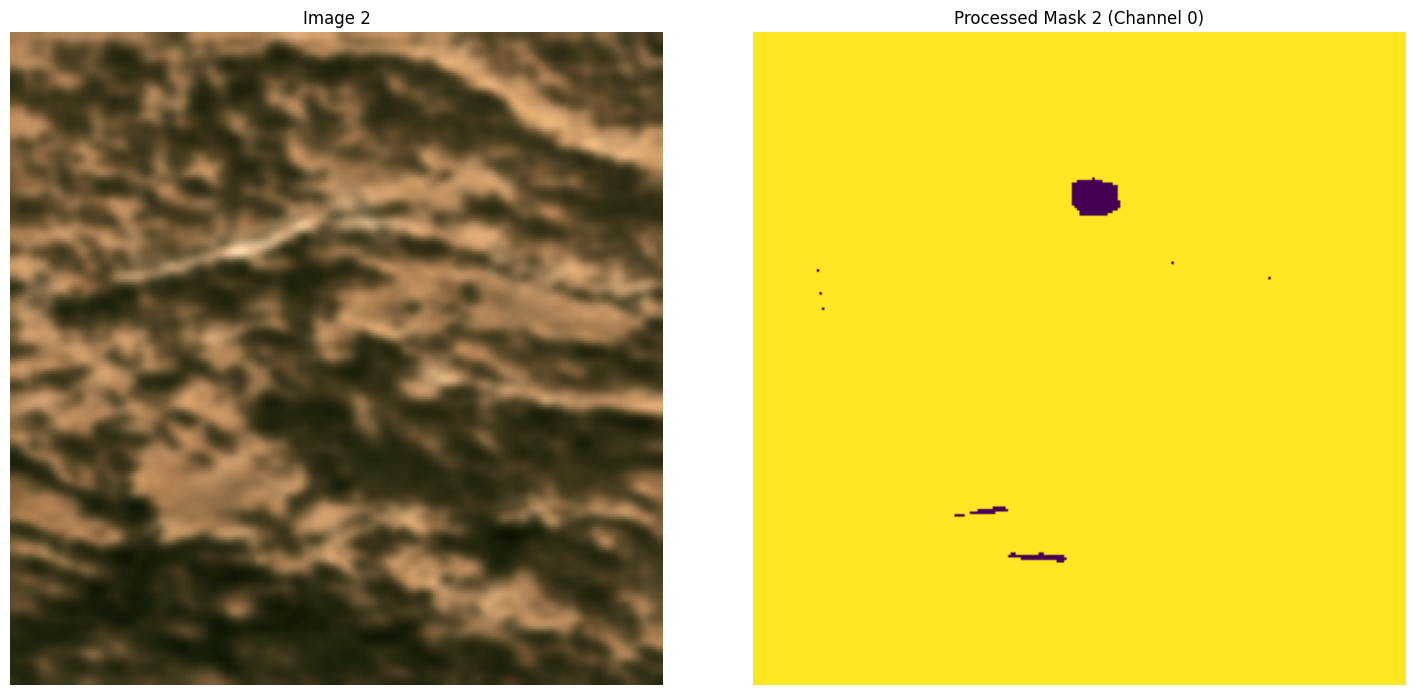


Image 3:
  Shape: (256, 256, 3), dtype: float32
Mask 3:
  Shape: (256, 256, 1), dtype: int32
  Unique mask values: [0]


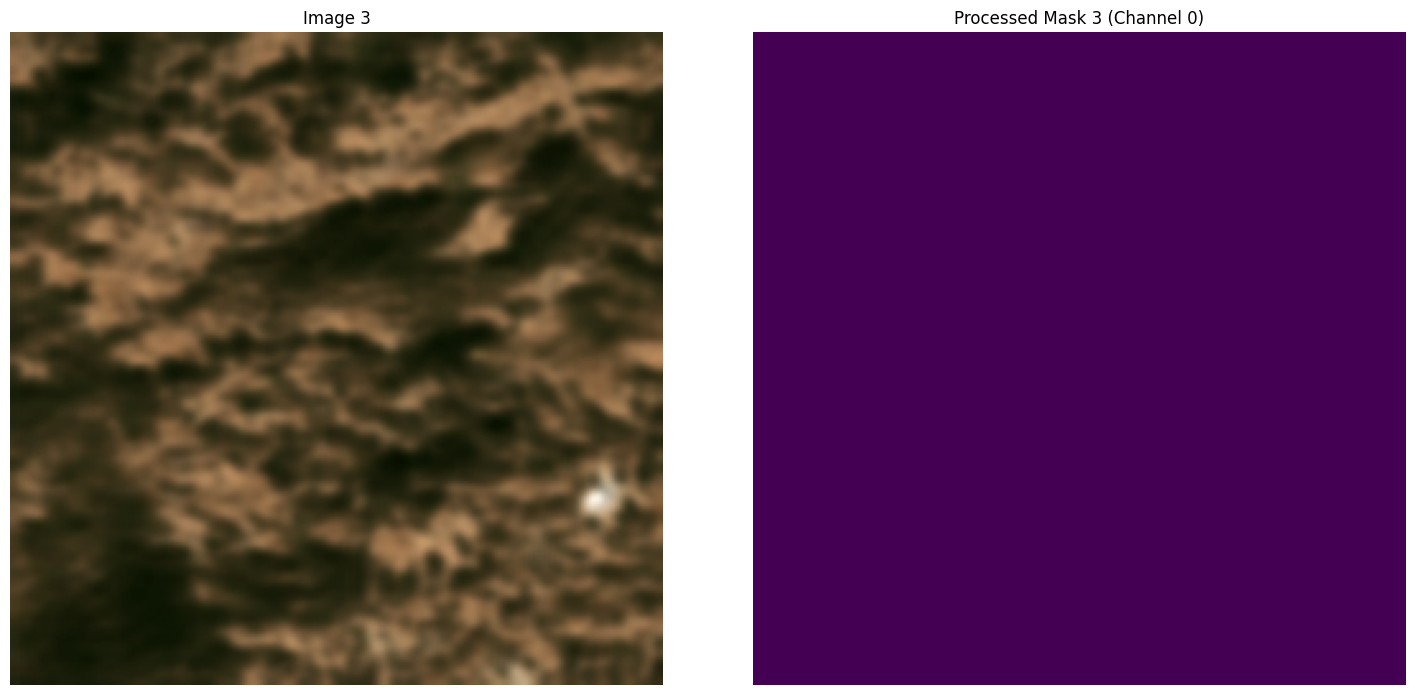


Image 4:
  Shape: (256, 256, 3), dtype: float32
Mask 4:
  Shape: (256, 256, 1), dtype: int32
  Unique mask values: [0 1]


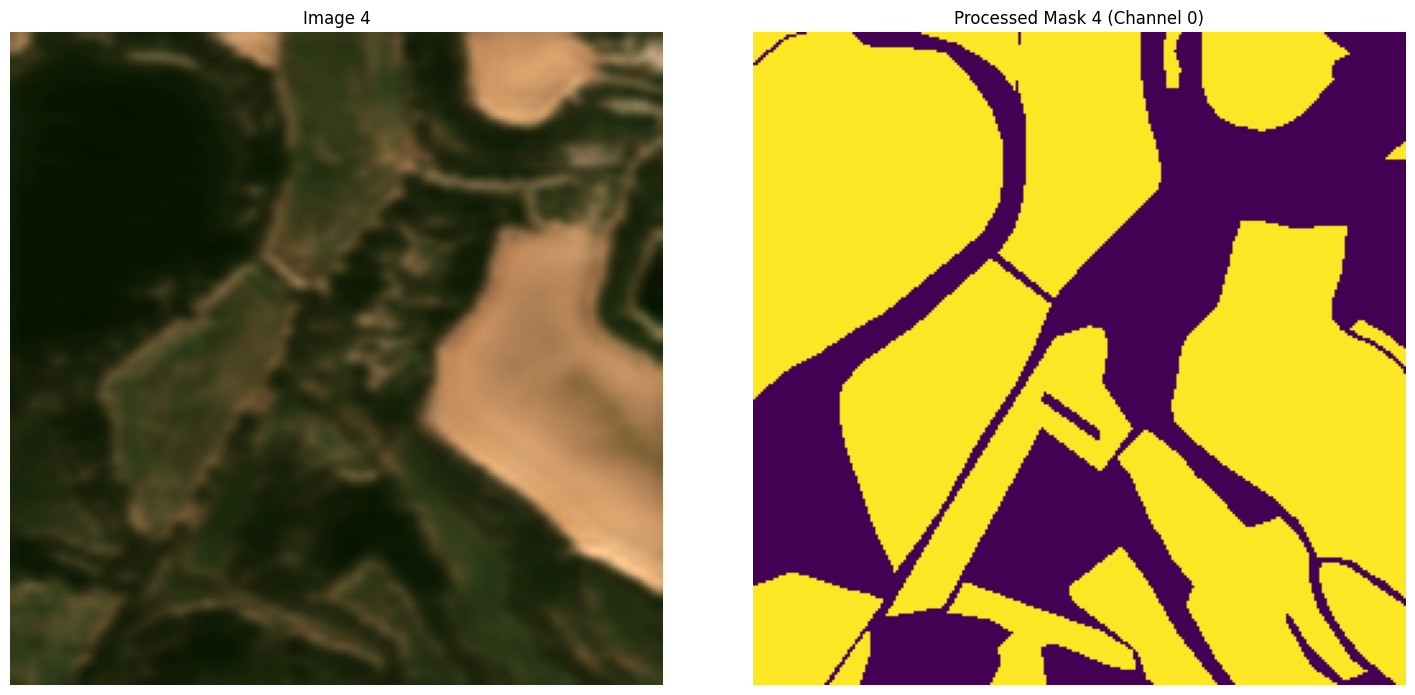

In [21]:

if img_val.any() and mask_val.any():

    show_images = min(5, len(img_val))
    print(f"\nDisplaying {show_images} example(s):")
    for i in range(show_images):

        img_view = img_val[i]
        mask_view = mask_val[i]


        print(f"\nImage {i}:")
        print(f"  Shape: {img_view.shape}, dtype: {img_view.dtype}")
        print(f"Mask {i}:")
        print(f"  Shape: {mask_view.shape}, dtype: {mask_view.dtype}")
        print(f"  Unique mask values: {np.unique(mask_view)}")

        fig, arr = plt.subplots(1, 2, figsize=(15, 7))


        arr[0].imshow(img_view)
        arr[0].set_title(f'Image {i}')
        arr[0].axis('off')

        arr[1].imshow(mask_view, cmap='viridis')
        arr[1].set_title(f'Processed Mask {i} (Channel 0)')
        arr[1].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("\nNo data loaded, skipping display.")

### Download pretrained model from GDrive

In [29]:
!ls -la /content/drive/MyDrive/dissertation/

total 509411
drwx------ 2 root root      4096 Apr 22 20:39 datasets
-rw------- 1 root root    827822 May 17 09:56 step1.unet-training-datsset1.ipynb.ipynb
-rw------- 1 root root   1271349 May 11 09:46 step2.unet-evaluate-dataset2.ipynb
-rw------- 1 root root 103906735 May 17 18:16 unet_basic_v1_128.keras
-rw------- 1 root root 103907080 May 16 13:28 unet_basic_v1_256.keras
-rw------- 1 root root 103907080 May 17 18:19 unet_basic_v1.keras
-rw------- 1 root root 103905674 May 16 15:07 unet_basic_v2.keras
-rw------- 1 root root 103905302 May 11 20:19 unet_basic_v3.keras


In [31]:
!cp ./drive/MyDrive/dissertation/unet_basic_v2.keras ./

In [32]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6,         # Lower bound on the learning rate.
    verbose=1,           # Print messages when reducing LR
    mode='min'           # 'min' because we want loss to decrease
)

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1}: Learning rate is {current_lr:.7f}.")
    def __init__(self):
        super().__init__()
        self.epoch_lrs = []
    def on_epoch_end(self, epoch, logs=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        self.epoch_lrs.append(current_lr)

lr_logger = LearningRateLogger()

In [33]:
class SegF1(tf.keras.metrics.Metric):
    def __init__(self, name="macro_f1", **kw):
        super().__init__(name=name, **kw)
        self.f1 = tf.keras.metrics.F1Score(average="macro", threshold=None)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # flatten to (N,) then expand to (N,1) → now 2-D
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(tf.argmax(y_pred, -1), [-1, 1])
        self.f1.update_state(y_true, y_pred, sample_weight)

    def result(self):       return self.f1.result()
    def reset_states(self): self.f1.reset_states()

In [34]:
unetv1 = tf.keras.models.load_model('./unet_basic_v1.keras', custom_objects={"SegF1": SegF1})

### Training

In [40]:
with tf.device('/device:GPU:0'):
  results = unetv1.fit(
      img_train,
      mask_train,
      batch_size=8,
      epochs=10,
      validation_data=(img_val, mask_val),
      callbacks=[reduce_lr_callback, lr_logger]
      )

Epoch 1: Learning rate is 0.0000016.
Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.8067 - crop_iou: 0.5930 - loss: 0.4498 - macro_f1: 0.7444 - val_accuracy: 0.7979 - val_crop_iou: 0.5521 - val_loss: 0.4640 - val_macro_f1: 0.7114 - learning_rate: 1.6000e-06
Epoch 2: Learning rate is 0.0000016.
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7978 - crop_iou: 0.5834 - loss: 0.4717 - macro_f1: 0.7369 - val_accuracy: 0.7980 - val_crop_iou: 0.5528 - val_loss: 0.4642 - val_macro_f1: 0.7120 - learning_rate: 1.6000e-06
Epoch 3: Learning rate is 0.0000016.
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8057 - crop_iou: 0.5698 - loss: 0.4537 - macro_f1: 0.7258 - val_accuracy: 0.7980 - val_crop_iou: 0.5529 - val_loss: 0.4638 - val_macro_f1: 0.7121 - learning_rate: 1.6000e-06
Epoch 4: Learning rate is 0.0000016.
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8110 - crop_iou: 0.6021 - loss: 0.4438 - macro_f1: 0.7513 

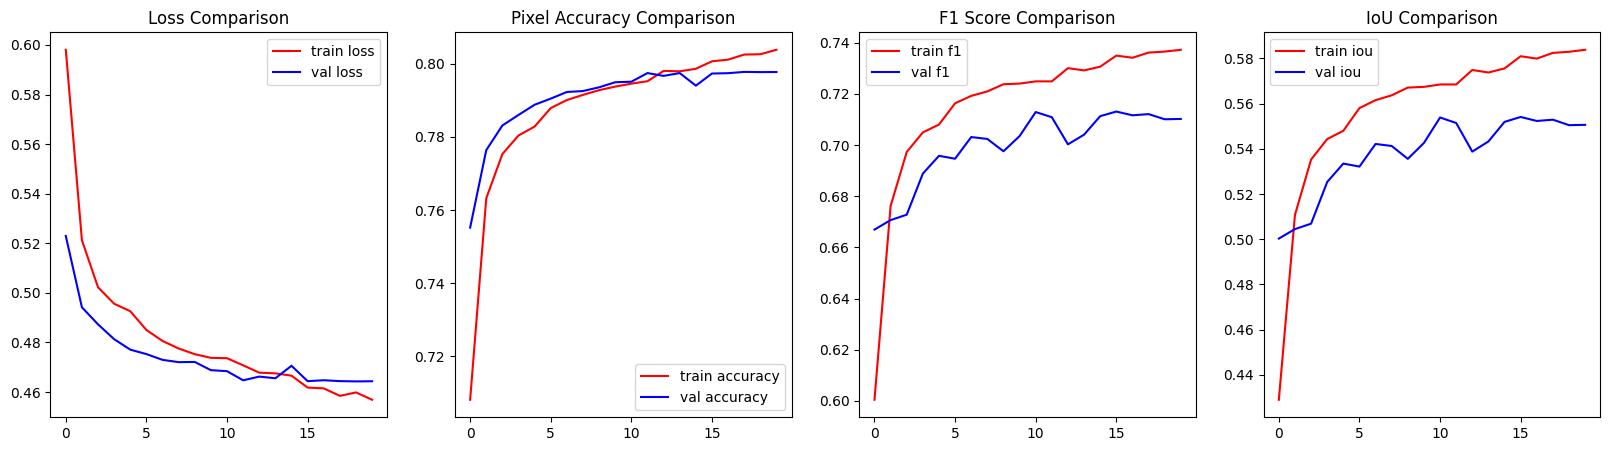

In [32]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 4, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Pixel Accuracy Comparison')
axis[1].legend()
axis[2].plot(results.history["macro_f1"], color='r', label = 'train f1')
axis[2].plot(results.history["val_macro_f1"], color='b', label = 'val f1')
axis[2].set_title('F1 Score Comparison')
axis[2].legend()
axis[3].plot(results.history["crop_iou"], color='r', label = 'train iou')
axis[3].plot(results.history["val_crop_iou"], color='b', label = 'val iou')
axis[3].set_title('IoU Comparison')
axis[3].legend()

### Evaluation of trained model

In [35]:
unetv1 = tf.keras.models.load_model('./unet_basic_v2.keras', custom_objects={"SegF1": SegF1})

In [36]:
with tf.device('/device:GPU:0'):
  res = unetv1.evaluate(img_val, mask_val)
  print("Evaluation:", res)

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step - accuracy: 0.7960 - crop_iou: 0.5434 - loss: 0.4687 - macro_f1: 0.7040
Evaluation: [0.4643363356590271, 0.7977012991905212, 0.5506324768066406, 0.7102036476135254]


In [34]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = img_train[index]
    img = img[np.newaxis, ...]
    pred_y = unetv1.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(img_train[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(mask_train[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


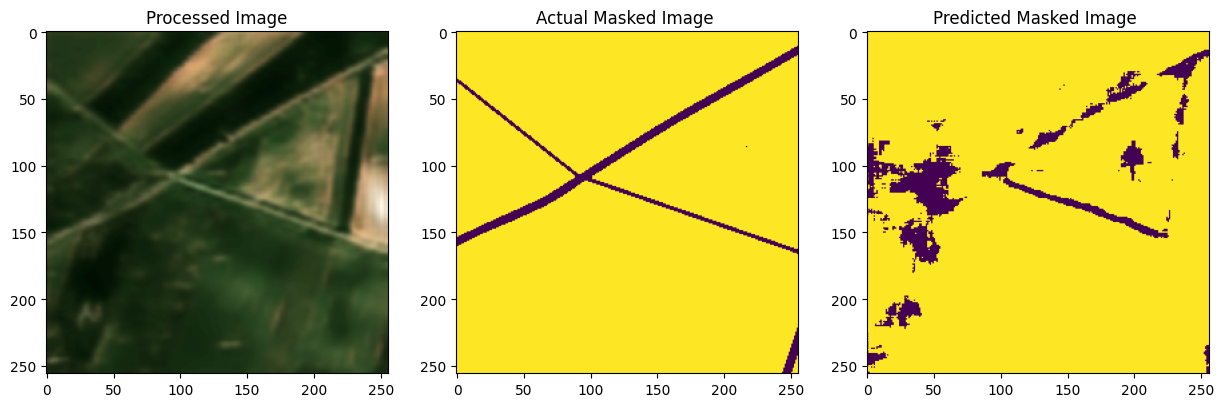

In [35]:
index = 19
VisualizeResults(index)

### Results

Model was fine tuned and showed improvement on pictures with new style.

Save new model

In [36]:
save_path = './unet_basic_v2.keras'

unetv1.save(save_path)

In [37]:
!ls -la ./

total 339020
drwxr-xr-x 1 root root      4096 May 16 15:06 .
drwxr-xr-x 1 root root      4096 May 16 14:30 ..
drwxr-xr-x 4 root root      4096 May 14 13:38 .config
drwx------ 7 root root      4096 May 16 14:37 drive
drwxr-xr-x 3 root root      4096 May 11 18:59 finetuning_dataset2
-rw------- 1 root root 139308205 May 16 14:37 finetuning_dataset.v2.tar.gz
drwxr-xr-x 1 root root      4096 May 14 13:38 sample_data
-rw------- 1 root root 103907080 May 16 14:52 unet_basic_v1_256.keras
-rw-r--r-- 1 root root 103905674 May 16 15:06 unet_basic_v2.keras


In [39]:
!cp ./unet_basic_v2.keras ./drive/MyDrive/dissertation/unet_basic_v2.keras